# ANOVA - Analysis of Variance

Today, we will be learning ANOVA, a generalized form of comparing means across multiple groups.

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Agenda

SWBAT:

- Compare and contrast $t$-tests with ANOVA;
- Differentiate between "variance between groups" and "variance within groups";
- Calculate ANOVA stats;
- Implement ANOVA in Python
    - using `statsmodels`

## $t$-tests or ANOVA?

**ANOVA** or *Analysis Of Variance*  provides a statistical test of whether two or more population means are equal, and therefore generalizes the $t$-test beyond two means.

Suppose we want to compare whether multiple groups differ in some measure. For example, we have collected mood data grouped by four types of weather - sunny, raining, overcast, or cloudy, and we want to find out whether there is a difference in mood across different weather. What tests would you use?

A natural reaction would be to conduct multiple $t$-tests. However, that comes with many drawbacks. First, you would need $\frac{n(n-1)}{2}$ t tests, which comes out to 6 tests. More tests means having a higher chance of making a Type I error. In this case, if our original probability of making a Type I error was $5\%$, it would now grow to $1-(1-0.05)^6 = 26\%$! By conducting 6 tests and comparing their means to each other, we are running a huge risk of making false positives. This is known as the **multiple comparisons problem**. How then, can we combat this? -- ANOVA!

Instead of looking at each individual difference, ANOVA examines the ratio of variance between groups, and variance within groups, to find out whether the ratio is big enough to be statistically significant. 

### $t$-Test statistics

##### One sample
$t = \frac{x\bar - \mu}{\frac{s}{\sqrt n}}$

##### Two sample
$$ t = \frac{\bar{x_1} - \bar{x_2}}{\sqrt{s^2 \left( \frac{1}{n_1} + \frac{1}{n_2} \right)}}$$

where $s^2$ is the pooled sample variance:

$$ s^2 = \frac{\sum_{i=1}^{n_1} \left(x_i - \bar{x_1}\right)^2 + \sum_{j=1}^{n_2} \left(x_j - \bar{x_2}\right)^2 }{n_1 + n_2 - 2} $$

We can also say that a $t$-test is a special case of ANOVA in that we are comparing the means of only two groups.

![img](img/choosing_test.png)


### ANOVA - the $F$ test

$F = \frac{s^2_{between}}{s^2_{within}}$

Just like $t$ and $z$ tests, we calculate a test statistic, then compare it to a critical value associated with a probability distribution. In this case, that distribution is the [$F$-distribution](https://en.wikipedia.org/wiki/F-distribution).

![fdistribution](img/f_distribution.png)

http://vassarstats.net/textbook/

In [2]:
np.random.seed(42)
one = np.random.normal(0, 3, 100)
two = np.random.normal(1, 3, 100)

In [3]:
# The "one-way" just means that there is a single
# input variable.

stats.f_oneway(one, two)

F_onewayResult(statistic=12.173874242028464, pvalue=0.0005972138330188013)

In [4]:
# Identical p_values

t = stats.ttest_ind(one, two, equal_var=True)
t

Ttest_indResult(statistic=-3.489107943590806, pvalue=0.0005972138330188009)

In [5]:
# The square of the two-sample t-stat = the F-stat
t.statistic**2

12.173874242028464

### Comprehension Check

Which test would you run for each these scenarios?

1. The average salary per month of an English Premier League player is €240,000. You would like to test whether players who don't have a dominant foot make more than the rest of the league. There are only 25 players who are considered ambidextrous. 

<details>
<summary>
    Check
</summary>
    - Predictor variable is categorical (dominant foot or not) <br/>
    - Outcome variable is quantitative (monthly salary) <br/>
    - Two groups compared <br/>
    - Therefore: $t$-test
        - ONE sample (comparing small ambidextrous sample with population)
        - ONE tail (MORE $ or not)
</details>

2. You would like to test whether there is a difference in arrest rates across neighborhoods with different racial majorities. You have point statistics of mean arrest rates associated with neighborhoods of majority White, Black, Hispanic, and Asian populations.

<details>
    <summary>
        Check
    </summary>
    ANOVA
</details>

3. You are interested in testing whether the superstition that black cats are bad luck affects adoption rate. You would like to test whether black-fur shelter cats get adopted at a different rate from cats of other fur colors.

<details>
    <summary>
        Check
    </summary>
    $t$-test
        - TWO samples (black cats and non-black cats)
        - TWO tails (greater or lesser rate)
</details>

4. You are interested in whether car-accident rates in cities where marijuana is legal differs from the general rate of car accidents. Assume you know the standard deviation of car accident rates across all U.S. cities.

<details>
    <summary>
        Check
    </summary>
    $z$-test
</details>

## 2. *Variance between groups* vs. *variance within groups*

<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/12/image046.png" width="500">

### Between Group Variability

Measures how much the means of each group vary from the mean of the overall population



<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/12/image0171.png" width="500">
    

### Within Group Variability

Refers to variations caused by differences within individual groups.  

Consider the given distributions of three samples below. As the spread (variability) of each sample is increased, their distributions overlap and they become part of a big population.
<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/12/image031.png" width="500">

Now consider another distribution of the same three samples but with less variability. Although the means of samples are similar to the samples in the above image, they seem to belong to different populations.

<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/12/image033.png" width="500">


Will three datasets with similar means have small $F$-statistics? Not necessarily.

In [6]:
# Create three sets of data without much difference in means
np.random.seed(42)

a = np.random.normal(loc=20, scale=20, size=20)
b = np.random.normal(loc=22, scale=20, size=20)
c = np.random.normal(loc=19, scale=20, size=20)

d = np.random.normal(loc=20, scale=2, size=20)
e = np.random.normal(loc=22, scale=2, size=20)
f = np.random.normal(loc=19, scale=2, size=20)

g = np.random.normal(loc=20, scale=10, size=20)
h = np.random.normal(loc=20, scale=10, size=20)
i = np.random.normal(loc=23, scale=10, size=20)

In [7]:
print(stats.f_oneway(a, b, c))
print(stats.f_oneway(d, e, f))
print(stats.f_oneway(g, h, i))

F_onewayResult(statistic=0.06693195000987277, pvalue=0.9353322377145488)
F_onewayResult(statistic=11.760064743099003, pvalue=5.2985391195830756e-05)
F_onewayResult(statistic=3.194250788724835, pvalue=0.048432238619556506)


## 3. Calculating ANOVA 
In this section, we will learn how to calculate ANOVA without using any packages. All we need to calculate is: 

<img src="attachment:Screen%20Shot%202019-06-03%20at%2010.36.09%20AM.png" width="400">

$\bar{X} = $ Mean of entire dataset


$SST$ = Total Sum of Squares is the sum of the squares of the difference between every value and $\bar X$.

- $SS_T$ = $\sum(X_{ij} - \bar X)^2$

The total sum of squares can be broken down into $SSB$, the sum of squares between, and $SSW$, the sum of squares within.

- $SS_T =  SS_B+SS_W$

$SSB$ accounts for the variance in the dataset that comes from the differences among the means of each sample.

- $SS_B$ = $\sum(n_i(\bar X - \bar{X_i})^2)$

$SSW$ accounts for the variance in the dataset that comes from within each sample.

- $SS_W$ = $\sum (n_i - 1) s_i ^ 2$  

Degrees of Freedom for ANOVA:
-  $DF_{between} = k - 1$
- $DF_{within} = N - k$
- $DF_{total} = N - 1$

Notation:
- $k$ is the number of groups
- $N$ is the total number of observations
- $n_i$ is the number of observations in each group

- $MS_B$ = $\frac{SS_B}{DF_B}$
- $MS_W$ = $\frac{SS_W}{DF_W}$
- $F$ = $\frac{MS_B}{MS_W}$

### Hypothesis Testing

Like $z$-tests and $t$-tests, we can also perform hypothesis testing with ANOVA. 

- $H_0$ : $\mu{_1}$ = $\mu_2$ = $\mu_3$ = $\mu_4$
- $H_a$ : $H_0$ is not true

In [8]:
df = pd.read_csv('data/bikeshare_day.csv')
df.head()
# cnt is the outcome we are trying to predict

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [9]:
# We need to conduct a little bit of feature engineering 
df['season_cat'] = df.season.apply(lambda x: 'spring' if x == 1 else 
                                           (
                                            'summer' if x == 2 else (
                                                'fall' if x == 3 else 'winter')
                                           )
                                      )
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_cat
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,spring
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,spring
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,spring
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,spring
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,spring


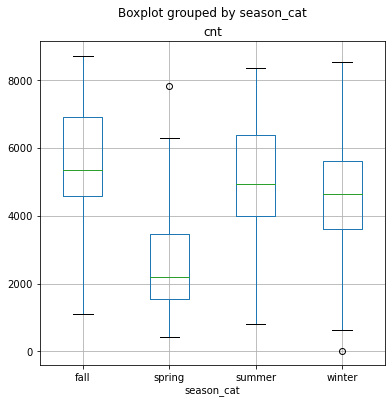

In [10]:
# Create a boxplot
# 1 is spring, 2 is summer, 3 is fall, and 4 is winter

df.boxplot('cnt', by='season_cat', figsize=(6,6));

In [11]:
# We could perform two-sample t-tests for each pair of samples.

# subset the dataframe  by season and isolate the dependent variable
spring = df[df.season_cat == 'spring'].cnt
fall = df[df.season_cat == 'fall'].cnt
summer = df[df.season_cat == 'summer'].cnt
winter = df[df.season_cat == 'winter'].cnt

# We could run independent t-tests for each combination
# But that increases the chance of making a type I (False Positive) error
# Also, as your groups increase, the number of tests may prove impractical

print(stats.ttest_ind(spring, fall, equal_var=False))
print(stats.ttest_ind(spring, summer, equal_var=False))
print(stats.ttest_ind(spring, winter, equal_var=False ))
print(stats.ttest_ind(fall, summer, equal_var=False))
print(stats.ttest_ind(fall, winter, equal_var=False))
print(stats.ttest_ind(summer, winter, equal_var=False))

Ttest_indResult(statistic=-20.421299365101394, pvalue=1.8275113489162628e-62)
Ttest_indResult(statistic=-14.681643583173908, pvalue=2.062553301642287e-38)
Ttest_indResult(statistic=-12.912947328222721, pvalue=2.3900124937362424e-31)
Ttest_indResult(statistic=3.970165339037975, pvalue=8.675073518101597e-05)
Ttest_indResult(statistic=5.518135906502346, pvalue=6.686180171635208e-08)
Ttest_indResult(statistic=1.4799678866927433, pvalue=0.13975747342519612)


In [12]:
# This time with ANOVA

 # 1. Calculate the overall mean.

X_bar = df.cnt.mean()
print('X_bar: ', X_bar)

 # 2. Define a variable that contains the total variability
 # of the dataset

MS_T = sum([(x - X_bar)**2 for x in df.cnt])
print('MS_T: ', MS_T)

 # 3. Define a variable that contains the variability of the
 # dataset that results from the difference of means.

MS_B = sum(
            [len(df[df.season_cat == season])*
             (X_bar 
             - np.mean(df[df.season_cat == season].cnt))**2 
             for season in df.season_cat.unique()
            ])
print('MS_B: ', MS_B)

 # 4. Define a variable that contains the variablity of the
 # dataset that results from the variance of each sample.
    
MS_W = sum(
            [(len(df[df.season_cat == season])-1)
             * np.var(df[df.season_cat == season].cnt, ddof=1)
             for season in df.season_cat.unique()
            ])
print('MS_W: ', MS_W)

 # 5. Sanity Check: Make sure all of the variability of the
 # dataset is accounted for by the two last answers.

print(np.allclose(MS_T, MS_B + MS_W))

 # 6. Define variables that contain the values of the two
 # important degrees of freedom.

df_B = 4 - 1
df_W = len(df) - 4

 # 7. Define a variable for the variance of weighted
 # individual group means.

MSB = MS_B / df_B
print('MSB: ', MSB)

 # 8. Define a variable for the variance of the weighted
 # individual group variances.

MSW = MS_W/df_W
print('MSW: ', MSW)

 # 9. Define the F-stat.

f_stat = MSB / MSW
print('F-stat: ', f_stat)

X_bar:  4504.3488372093025
MS_T:  2739535392.046512
MS_B:  950595868.4582922
MS_W:  1788939523.5882194
True
MSB:  316865289.4860974
MSW:  2460714.6129136444
F-stat:  128.7696215657079


In [13]:
9 # Ensure that the prior calculation matches the output below:

f = stats.f_oneway(df['cnt'][df['season_cat'] == 'summer'],
                df['cnt'][df['season_cat'] == 'fall'], 
                df['cnt'][df['season_cat'] == 'winter'],
                df['cnt'][df['season_cat'] == 'spring'])

np.allclose(f.statistic, f_stat)

True

In [14]:
f.statistic

128.76962156570784

In [15]:
f.pvalue

6.720391362913176e-67

## 4. First Glimpse of Statsmodels OLS Method

In [16]:
anova_season = ols('cnt ~ season_cat', data=df).fit()
anova_season.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     128.8
Date:                Thu, 01 Apr 2021   Prob (F-statistic):           6.72e-67
Time:                        13:38:40   Log-Likelihood:                -6413.9
No. Observations:                 731   AIC:                         1.284e+04
Df Residuals:                     727   BIC:                         1.285e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             5644.3032    114.407     49.335      0.000    5419.696    5868.910
season_cat[T.spring] -3040.1706    163.352    -18.611      0.000   -3360.869   -2719.472
season_cat[T.summer]  -651.9717    162.673     -4.008      0.000    -971.336    -332.608
season_cat[T.winter]  -916.1403    164.052     -5.584      0.000   -1238.213    -594.068
==============================================================================
Omnibus:                        3.050   Durbin-Watson:                   0.469
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                2.765
Skew:                           0.080   Prob(JB):                        0.251
Kurtosis:                       2.745   Cond. No.                         4.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Next steps

Just because we have rejected the null hypothesis, it doesn't mean we have conclusively shown which group is significantly different from which - remember, the alternative hypothesis says simply that the null hypothesis is not true.

We need to conduct post-hoc tests for multiple comparisons to find out which groups are different. The most prominent post-hoc tests are:
- LSD (Least significant difference)
    - $t\sqrt \frac{MSE}{n^2}$
- Tukey's HSD 
    - $q\sqrt \frac{MSE}{n}$
    
https://www.statisticshowto.com/studentized-range-distribution/#qtable
    
After calculating a value for LSD or HSD, we compare each pair wise mean difference with the LSD or HSD difference. If the pairwise mean difference exceeds the LSD/HSD, then they are significantly different.

In [17]:
print(pairwise_tukeyhsd(df.cnt, df.season_cat))

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
  fall spring -3040.1706  0.001 -3460.8063 -2619.5349   True
  fall summer  -651.9717  0.001 -1070.8566  -233.0867   True
  fall winter  -916.1403  0.001 -1338.5781  -493.7025   True
spring summer  2388.1989  0.001  1965.3265  2811.0714   True
spring winter  2124.0303  0.001  1697.6383  2550.4224   True
summer winter  -264.1686 0.3792  -688.8337   160.4965  False
------------------------------------------------------------


## Two-Way ANOVA:

Returning to the example at the very beginning of the lesson, say 
we found out, using one-way ANOVA, that the season was impactful on the mood of different people. What if the season was to affect different groups of people differently?  Maybe older people were affected more by the seasons than younger people.

Moreover, how can we be sure as to which factor(s) is affecting the mood more? Maybe the age group is a more dominant factor responsible for a person's mood than the season.

For such cases, when the outcome or dependent variable is affected by two independent variables/factors we use a slightly modified technique called two-way ANOVA.

## More Resources

https://www.analyticsvidhya.com/blog/2018/01/anova-analysis-of-variance/
    
https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/anova/how-to/one-way-anova/before-you-start/overview/